<font size="5"> **Mixed layer depth in the Southern Ocean** </font>  
  
This script produces plots of Mixed Layer Depth (MLD) around the Southern Ocean using outputs from ACCESS-OM2-01. It also compares model outputs to observations.
  
**Requirements:** It is suggested you use the `conda/analysis3-21.10` (or later). This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a code cell.

# Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
import os
from glob import glob
import re
from collections import OrderedDict
# from datetime import datetime
import calendar
#Importing script containing functions developed to calculate timeseries
import ZonalStatsFunctions as zsf
import netCDF4 as nc
import datetime as dt
import cftime
import xesmf as xe
import rioxarray
from scipy.io import loadmat
import xesmf as xe
from itertools import cycle
import scipy.stats as ss
import string

The following modules are used in plotting maps and time series.

In [2]:
#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import matplotlib.cm as mcm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm           
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec
import geopandas

#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

# Accessing ACCESS-OM2-01 outputs
Start a cluster that has multiple cores to work with. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [3]:
client = Client(n_workers = 8)

Access the default database of experiments from where data will be loaded.

In [4]:
session = cc.database.create_session()

This notebook uses outputs for the second cycle, v140 run of ACCESS-OM2-01, which includes wind forcing. A list of ACCESS-OM2-01 experiments can be accessed using `cc.querying.get_experiments(session)`. A detailed list of experiments can be obtained by adding the following argument: `all = True`.

## Set up variable dictionary prior ACCESS-OM2 model outputs
Once the correct experiment variables have been identified, data can be loaded into the notebook for further processing. All variables needed to do this are included below.

In [4]:
varDict =  {'var_id': 'mld',
            'model': 'ACCESS-OM2-01',
            'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
            'freq': '1 monthly',
            'start_date': range(1965, 2018, 1),
            'offset': np.nan,
            'long_name': 'mixed layer depth',
            'short_name': 'MLD',
            'unit': 'm',
            'CICE_data': False,
            'base_data': r'/g/data/v45/la6889/Calculations/MLD/Data',
            'climatologies': r'/g/data/v45/la6889/Calculations/MLD/Climatologies',
            'clim_fig': r'/g/data/v45/la6889/Figures/MLD/Climatologies',
            'linear_trends': r'/g/data/v45/la6889/Calculations/MLD/LinearTrends',
            'std_err': r'/g/data/v45/la6889/Calculations/MLD/Std_Errors',
            'lm_fig': r'/g/data/v45/la6889/Figures/MLD/LinearTrends',
            'clipped_data': r'/g/data/v45/la6889/Calculations/MLD/ClippedMEASOregions/',
            'weighted_means_season': r'/g/data/v45/la6889/Calculations/MLD/YearlySeasonal/Means',
            'weighted_means_monthly': r'/g/data/v45/la6889/Calculations/MLD/YearlyMonthly/Means',
            'weighted_std_monthly': r'/g/data/v45/la6889/Calculations/MLD/YearlyMonthly/StdDev',
            'decades': range(1965, 2019, 10),
            'weighted_means_dec_season': r'/g/data/v45/la6889/Calculations/MLD/DecadalSeasonal/Means',
            'weighted_means_dec_monthly': r'/g/data/v45/la6889/Calculations/MLD/DecadalMonthly/Means',
            'mean_sector_time_series': r'/g/data/v45/la6889/Figures/MLD/TimeSeries/',
            'res': '0.1°'}

## Accessing ACCESS-OM2 outputs and saving results to disk

In [ ]:
dir_out = varDict['base_data']
os.makedirs(dir_out, exist_ok = True)

for yr in varDict['decades']:
    #Accessing data per decade
    stime = f'{str(yr)}-01'
    etime = f'{str(yr+9)}-12'
    #Accessing ACCESS 0.1deg outputs for the entire time range of interest
    SO = zsf.getACCESSdata(varDict['var_id'], stime, etime,
                           freq = varDict['freq'], 
                           ses = session, minlat = -80, maxlat = -35,
                           ice_data = False)
    #Removing time bounds attribute causing issues when saving data
    del SO.attrs['time_bounds']
    
    #Correcting longitudes
    SO = zsf.corrlong(SO)
    #Creating name of file    
    fn = f'MixedLayerDepth_{str(yr)}-{str(yr+9)}.nc'
    #Saving file
    SO.to_netcdf(os.path.join(dir_out, fn))

### Loading longitude corrected MLD data from disk

In [5]:
#Get list of files in disk
filelist = sorted(glob(os.path.join(varDict['base_data'], '*.nc')))

#Empty list to store files
SO = []

#Loading single files
for i, file in enumerate(filelist):
    stime = str(varDict['decades'][i]-1) + '-12'
    etime = str(varDict['decades'][i]+9) + '-11'
    x = xr.open_dataarray(file).sel(time = slice(stime, etime))
    SO.append(x)

#Concantenating all files into a single data array
SO = xr.concat(SO, dim = 'time')

## Loading MEASO regions to overlay them on plots

<AxesSubplot:>

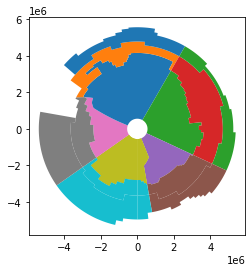

In [6]:
#Load shapefile
MEASO = geopandas.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo.shp')

#Remove temperate zones as they are not within area of interest
MEASO = MEASO.query('zone != "Temperate"')

#Add a column with the long name for each MEASO area
MEASO = MEASO.assign(long_name = (MEASO.sector + ' ' + MEASO.zone).to_list())

#Checking results
MEASO.plot(column = 'long_name')

# Calculating climatologies for variable of interest across the Southern Ocean
The satellite period (1979-2008) was chosen to calculate climatologies, and three climatologies were calculated:
- Overall, which includes the mean for the entire climatological period
- Seasonal, which is the mean value per season over the climatological period
- Monthly, which is the mean monthly value over the climatological period

Calculations are done in this way to avoid issues with memory.

In [20]:
clim_overall = zsf.climCalc(SO, [1979, 2008], clim_type = 'overall', 
                            varname = varDict['short_name'],
                            folder_out = varDict['climatologies'])

clim_seasonal = zsf.climCalc(SO, [1979, 2008], clim_type = 'seasonal', 
                             varname = varDict['short_name'],
                             folder_out = varDict['climatologies'])

clim_monthly = zsf.climCalc(SO, [1979, 2008], clim_type = 'monthly', 
                            varname = varDict['short_name'],
                            folder_out = varDict['climatologies'])

## Loading climatologies and plotting them

### Overall Climatology

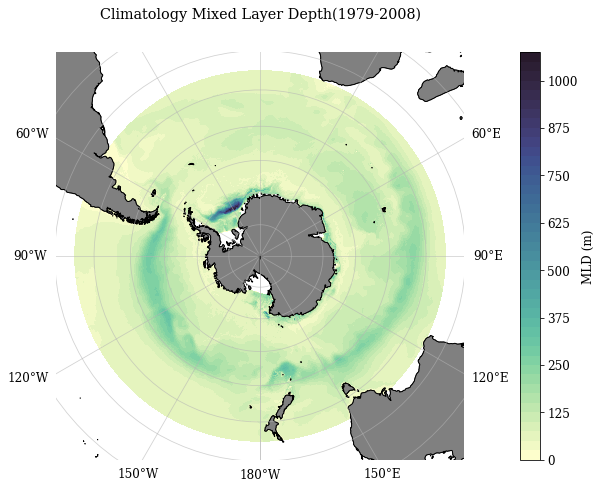

In [121]:
filepath = glob(os.path.join(varDict['climatologies'], '*overall*.nc'))

clim_overall = xr.open_dataarray(filepath[0])

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 7.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Setting color palette levels
maxv = np.ceil(float(clim_overall.max().values))+25
levels = np.arange(0, maxv, 25)

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

ax = fig.add_subplot(111, projection = projection)

#Add contour plot of sea ice advance
p = clim_overall.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', levels = levels,
                                 ax = ax, cmap = cm.cm.deep, 
                                transform = ccrs.PlateCarree(), 
                                add_colorbar = False)

#Add land and coastlines
ax.add_feature(land_50m)
ax.coastlines(resolution = '50m')

#Apply colourbar to figure and set it to be horizontal
cb = fig.colorbar(p, ax = ax, label = (varDict['short_name'] + ' (' + varDict['unit'] + ')'), pad = 0.1)

#Add title
ax.set_title('Climatology ' + varDict['long_name'].title() + '(1979-2008)')

#Draw gridlines
gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
#Locate longitude ticks - Set to every 30 deg
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#Give longitude labels the correct format for longitudes
gl.xformatter = LONGITUDE_FORMATTER
#Set rotation of longitude labels to zero
gl.xlabel_style = {'rotation': 0}
#Set latitude labels to be transparent
gl.ylabel_style = {'alpha': 0}
#Add space between axis ticks and labels for x and y axes
gl.xpadding = 9
gl.ypadding = 9
gl.xlabels_left = False
gl.xlabels_right = True
gl.xlabels_top = False

#Remove the outside frame and ticklines of the figure
[s.set_visible(False) for s in ax.spines.values()]
[t.set_visible(False) for t in ax.get_xticklines()]
[t.set_visible(False) for t in ax.get_yticklines()]

fn = 'OverallClimatology_' + varDict['short_name'] + '_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

### Seasonal Climatology

In [21]:
year_range = [1965, 2018]
clim_seasonal = zsf.climCalc(SO, year_range, clim_type = 'seasonal', 
                             varname = varDict['short_name'],
                             folder_out = varDict['climatologies'])

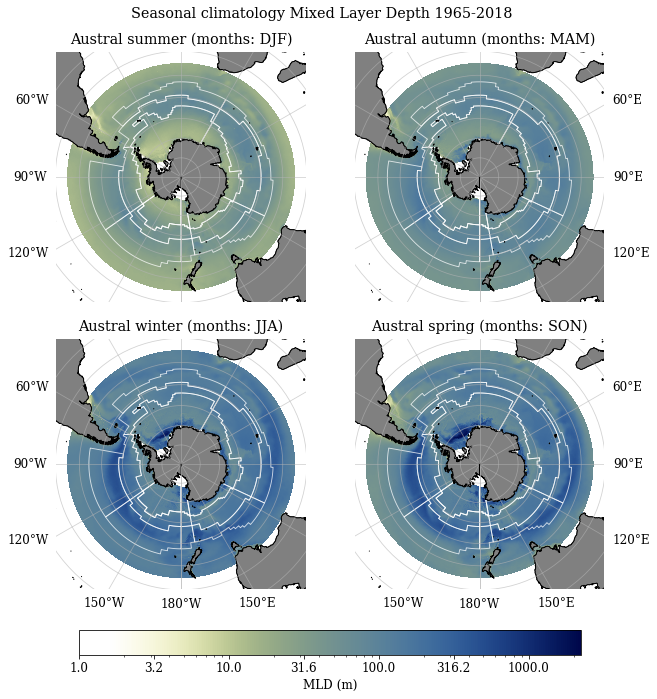

In [96]:
#Get full path for seasonal climatology
filepath = glob(os.path.join(varDict['climatologies'], '*seasonal_1965*.nc'))

#Load data
clim_seasonal = xr.open_dataarray(filepath[0])

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Create log scale for colorbar
log_norm = mcolors.LogNorm(vmin = clim_seasonal.min().values, 
                           vmax = clim_seasonal.max().values)
#Create a list for ticks
cbar_ticks = [10**i for i in np.arange(np.floor(np.log10(clim_seasonal.min().values)),
                                       round(np.log10(clim_seasonal.max().values), 3), 0.5)]

#Get a colormap from Scientific Colour Maps
cmap, cmap_r = zsf.colourMaps('../../ScientificColourMaps6/', 'davos', rev = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
#Ensure labels created using LaTeX appear as regular text
plt.rcParams.update({'mathtext.default': 'regular'})

#Defining season names
seasonName = {'DJF': 'Austral summer', 'MAM': 'Austral autumn', 
              'JJA': 'Austral winter', 'SON': 'Austral spring'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.15)

#Initialise list to save figure axes
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'DJF'), (0, 1, 'MAM'), (1, 0, 'JJA'), (1, 1, 'SON')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
        
    #Extract information for each season and start plotting
    p1 = clim_seasonal.sel(season = season).\
    plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax[season], 
                    #Use colormap created at the beginning of the block and apply log-transformed colormap
                    cmap = cmap_r, norm = log_norm,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
    #Overlay MEASO regions
    MEASO.plot(color = 'none', lw = 0.9, ax = ax[season], edgecolor = 'white',
              alpha = 0.75)
    
    #Set title for each subplot.
    ax[season].set_title(seasonName[season] + ' (months: ' + season + ')', y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
        
    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set shared colourbar for all plots
cb = fig.colorbar(p1, ax = [ax[a] for a in ax], orientation = 'horizontal', 
                  shrink = 0.9, pad = 0.06, 
                  label = varDict['short_name'] + ' (' + varDict['unit'] + ')')
#Show colorbar ticks
cb.set_ticks(cbar_ticks)
cb.set_ticklabels(np.round(cbar_ticks, 1))
    
fig.suptitle('Seasonal climatology ' + varDict['long_name'].title() + f' {year_range[0]}-{year_range[1]}',
             y = 0.93)

fn = 'SeasonalClimatology_' + varDict['short_name'] + f'_{year_range[0]}-{year_range[1]}.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# MLD timeseries per MEASO sectors

In [7]:
#Loading mask
regions = xr.load_dataarray('MEASO_3Dmask.nc')

#Defining sector names in order
sectorNames = regions.region.values

#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for sec in sectorNames:
    MEASOregions[sec] = regions.sel(region = sec)
    
MEASOregions.keys()

dict_keys(['West Pacific Antarctic', 'West Pacific Subantarctic', 'West Pacific Northern', 'Atlantic Antarctic', 'Atlantic Northern', 'Atlantic Subantarctic', 'Central Indian Antarctic', 'Central Indian Northern', 'Central Indian Subantarctic', 'East Indian Antarctic', 'East Indian Northern', 'East Indian Subantarctic', 'East Pacific Antarctic', 'East Pacific Northern', 'East Pacific Subantarctic'])

## Clipping MLD data

In [ ]:
#Ensuring output folder exists
out_folder = varDict['clipped_data']
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_MLD = {}

#Range of years included in data
minY = SO.time.dt.year.values.min()
maxY = SO.time.dt.year.values.max()

#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    clipped_MLD[sector] = SO*MEASOregions[sector]
    #Create name for output file
    fn = f'MLD_{sector}_{minY}-{maxY}.nc'
    clipped_MLD[sector].to_netcdf(os.path.join(out_folder, fn))

### Loading clipped data to avoid recalculation

In [8]:
filelist = glob(os.path.join(varDict['clipped_data'], '*.nc'))

#Create empty list to save clipped data 
clipped_MLD = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    clipped_MLD[sector] = xr.open_dataarray(fn[0])

### Loading clipped area data per sector

In [8]:
filelist = glob(os.path.join('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/AllMEASOsectors', '*.nc'))

#Create empty list to save clipped data 
area = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    area[sector] = xr.open_dataarray(fn[0])

## Time series calculation

In [9]:
#Defining sectors of interest
sub_sectors = ['Central Indian Antarctic', 'East Pacific Antarctic']

In [10]:
#Create empty list to save timeseries data 
weighted_MLD = {}

#Extracting years of interest in the data arrays
years = np.unique(clipped_MLD['Atlantic Antarctic'].time.dt.year.values)

for sector in sub_sectors:
    #Empty variable to store weighted clipped data 
    w_clip = []
    #Loop through all years - Extracting data per MEASO sector
    for yr in years[:-1]:
        clip_yr = clipped_MLD[sector].sel(time = slice(f'{str(yr)}-12', f'{str(yr+1)}-11'))
        #Calculated weighted means per season per year
        w_clip.append(zsf.weightedMeans(clip_yr, area[sector], meanby = 'season').expand_dims({'time':[yr+1]}))
    #Store weighted means in dictionary
    weighted_MLD[sector] = xr.concat(w_clip, dim = 'time')

In [11]:
#Defining seasons of interest
seasonName = {'DJF': 'Austral summer', 'JJA': 'Austral winter'}

#Creating empty dictionary to store results of linear regression
results_LM = {}

for sector in sub_sectors:
    #Extract data per sector
    mld = weighted_MLD[sector]
    for season in seasonName:
        #Select data per season
        mld_season = mld.sel(season = season)
        #Create key to store data in dictionary
        key = f'{sector}_{season}'
        #Calculating linear regression
        res = ss.linregress(mld_season.time.values, mld_season.values)
        res_pd = pd.DataFrame(np.transpose(np.array([[val] for val in res])), 
                              columns = [f for f in res._fields])
        #Store results as data array
        results_LM[key] = xr.DataArray(res_pd, dims = ['sector_season', 'LM_result'], 
                     coords = {'sector_season': [key],
                      'LM_result': [f for f in res._fields]})

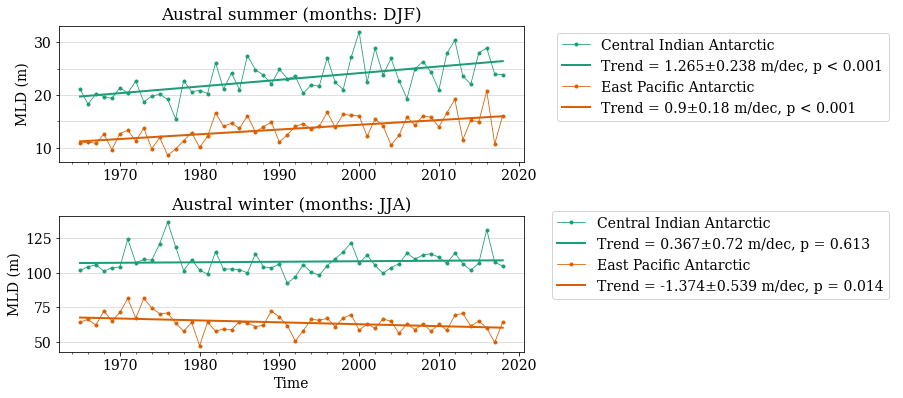

In [289]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

fig = plt.figure(figsize = (15, 6))
#Create grid to show plots
gs = gridspec.GridSpec(nrows = 1, ncols = 2, width_ratios = (1, 0.5))

#Change the width between each plot
gs.update(wspace = 0.4, hspace = 1)

#Empty list to store axes 
ax = {}

seasonName = {'DJF': 'Austral summer', 'JJA': 'Austral winter'}
colors = ['#1b9e77', '#d95f02']
gsub = gs[0].subgridspec(2, 1, hspace = 0.4)
gleg = gs[1].subgridspec(2, 1)

for i, season in enumerate(seasonName):
    ax[season] = fig.add_subplot(gsub[i])
    ax[f'{season}_leg'] = fig.add_subplot(gleg[i])
    for sec, col in zip(weighted_MLD, colors):
        mld_sea = weighted_MLD[sec].sel(season = season)
        lm_sec = results_LM[f'{sec}_{season}'][0]
        mld_sea.plot(ax = ax[season], color = col, linewidth = 0.8, 
                     marker = 'o', markersize = 3, label = sec)
        slope = lm_sec.sel(LM_result = 'slope').values
        err = lm_sec.sel(LM_result = 'stderr').values
        p_val = lm_sec.sel(LM_result = 'pvalue').values
        if p_val < 0.001:
            p_val = 'p < 0.001'
        else:
            p_val = f'p = {np.round(p_val, 3)}'
        pred = lm_sec.sel(LM_result = 'intercept')+(slope*mld_sea.time)
        ax[season].plot(mld_sea.time, pred, color = col, linewidth = 2,
                       label = f'Trend = {np.round(slope*10, 3)}\u00B1{np.round(err*10, 3)} m/dec, {p_val}')
        ax[season].set_title(f'{seasonName[season]} (months: {season})')
        ax[season].set_ylabel('MLD (m)')
        ax[season].xaxis.set_minor_locator(AutoMinorLocator(n = 5))
        
        #Legend
        h, l = ax[season].get_legend_handles_labels()
        ax[f'{season}_leg'].legend(h, l)
        ax[f'{season}_leg'].axis('off')
        
ax['DJF'].set_xlabel('')
ax['JJA'].set_xlabel('Time')

# For the minor ticks, use no labels; five minor ticks to be included between each major tick pair (i.e., every two years)
ax['DJF'].yaxis.set_minor_locator(AutoMinorLocator(n = 2))
ax['DJF'].grid(axis='y', which = 'both', alpha = 0.5)
ax['JJA'].grid(axis='y', which = 'both', alpha = 0.5)
        
plt.savefig(os.path.join(varDict['lm_fig'], 'Timeseries_CI_EP.png'),
            dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

# Comparing MLD in cycle 2 and cycle 3

## Loading data from different cycles

In [6]:
#Data from cycle 2
SO_2 = zsf.getACCESSdata(varDict['var_id'], '1979-01', '2008-12',
                           freq = varDict['freq'], exp = '01deg_jra55v140_iaf_cycle2',
                           ses = session, minlat = -80, maxlat = -35,
                           ice_data = False)

#Remove time bounds attribute that is not needed
del SO_2.attrs['time_bounds']
#Correcting longitudes
SO_2 = zsf.corrlong(SO_2).sel(time = slice('1979-01', '2008-12'))

In [7]:
#Data from cycle 3
SO_3 = zsf.getACCESSdata(varDict['var_id'], '1979-01', '2008-12',
                           freq = varDict['freq'], exp = '01deg_jra55v140_iaf_cycle3',
                           ses = session, minlat = -80, maxlat = -35,
                           ice_data = False)

#Remove time bounds attribute that is not needed
del SO_3.attrs['time_bounds']
SO_3 = zsf.corrlong(SO_3).sel(time = slice('1979-01', '2008-12'))

## Calculating climatology and saving outputs for each cycle

In [14]:
#Calculate climatologies for each cycle
SO_2_clim = SO_2.groupby('time.season').mean('time')
SO_3_clim = SO_3.groupby('time.season').mean('time')

#Saving outputs
#Folder path
folder_out_2 = varDict['climatologies']
folder_out_3 = os.path.join(varDict['climatologies'], 'cycle3')
#Saving data
SO_2_clim.to_netcdf(os.path.join(folder_out_2, 'MLD_Climatology_seasonal_1979-2008.nc'))
SO_3_clim.to_netcdf(os.path.join(folder_out_3, 'MLD_Climatology_seasonal_1979-2008.nc'))

## Plotting both cycles

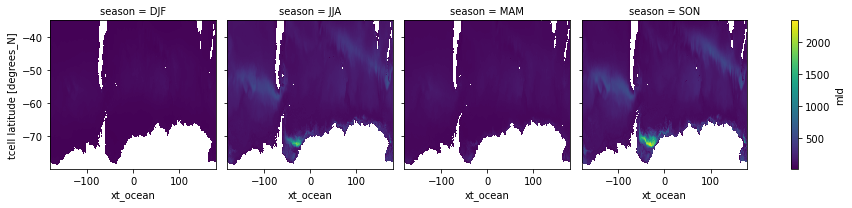

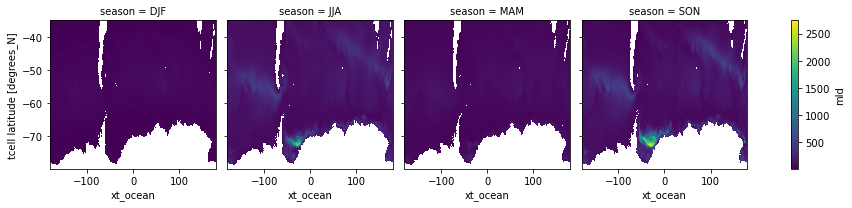

In [22]:
#Plotting cycle 2 on top and cycle 3 at the bottom
SO_2_clim.plot(col = 'season')
SO_3_clim.plot(col = 'season')

## Calculating differences between cycles
Positive values represent areas where MLD was deeper in cycle 2, while negative values show the areas where MLD was shallower in cycle 2.

In [39]:
#Calculating difference between cycles
diff_2_3 = SO_2_clim-SO_3_clim

## Plotting cycle differences

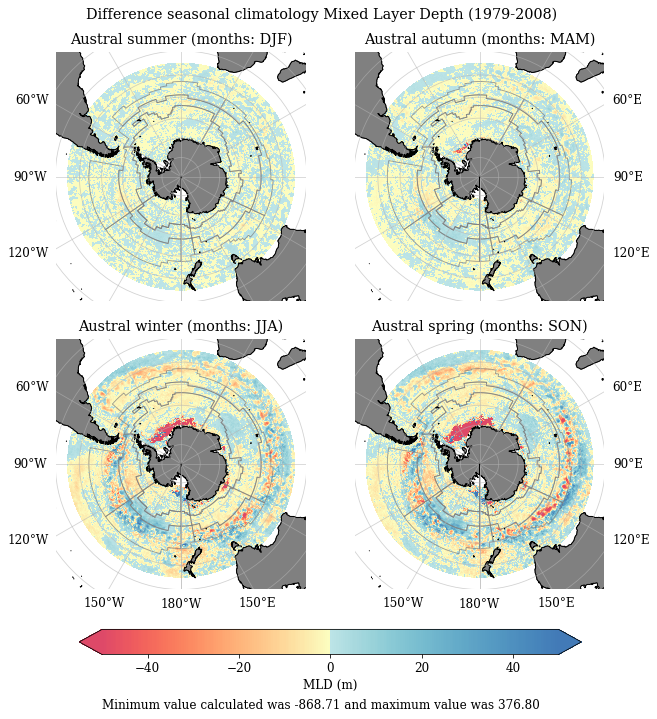

In [72]:
#Ensure folder where figures will be saved exists
folder_out = os.path.join(varDict['clim_fig'], 'cycle3')
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Colormap settings
#Levels for colorbar
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -50, vcenter = 0, vmax = 50)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.6, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.5, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.\
from_list('my_colormap', colors)
mymap.set_bad('white')

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
#Ensure labels created using LaTeX appear as regular text
plt.rcParams.update({'mathtext.default': 'regular'})

#Defining season names
seasonName = {'DJF': 'Austral summer', 'MAM': 'Austral autumn', 
              'JJA': 'Austral winter', 'SON': 'Austral spring'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.15)

#Initialise list to save figure axes
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'DJF'), (0, 1, 'MAM'), (1, 0, 'JJA'), (1, 1, 'SON')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
        
    #Extract information for each season and start plotting
    p1 = diff_2_3.sel(season = season).\
    plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax[season], 
                    #Use colormap created at the beginning of the block and apply log-transformed colormap
                    cmap = mymap, norm = divnorm,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
    
    #Overlay MEASO regions
    MEASO.plot(color = 'none', lw = 0.9, ax = ax[season], edgecolor = 'grey',
              alpha = 0.75)
    
    #Set title for each subplot.
    ax[season].set_title(seasonName[season] + ' (months: ' + season + ')', y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
        
    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set shared colourbar for all plots
cb = fig.colorbar(p1, ax = [ax[a] for a in ax], orientation = 'horizontal', 
                  shrink = 0.9, pad = 0.06, extend = 'both',
                  label = varDict['short_name'] + ' (' + varDict['unit'] + ')')

#Adding note in caption
min_val = diff_2_3.min().values
max_val = diff_2_3.max().values
fig.text(.5, .15, f'Minimum value calculated was {min_val:.2f} and maximum value was {max_val:.2f}', 
         ha = 'center')

fig.suptitle('Difference seasonal climatology ' + varDict['long_name'].title() + ' (1979-2008)',
             y = 0.93)

fn = 'DifferenceRuns_SeasonalClimatology_' + varDict['short_name'] + '_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Calculating linear trends in mixed layer depth

## Defining seasons

In [9]:
seasonName = {'Summer': [12, 1, 2], 'Autumn': [3, 4, 5], 
              'Winter': [6, 7, 8], 'Spring': [9, 10, 11]}

## Separating data into seasons

In [10]:
#Selecting satellite period
climdata = SO.sel(time = slice('1978-12', '2008-11'))

#Initialising empty dictionary to store seasonal data 
seasons_SO = {}

#Splitting data into seasons
for season in seasonName.keys():
    y = []
    for i, m in enumerate(climdata.time.dt.month.values.tolist()):
        if m in seasonName[season]:
            y.append(climdata[i])
    #Saving data into dictionary
    seasons_SO[season] = xr.concat(y, dim = 'time')

## Calculating linear trends for model data

In [11]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Calculating linear trend for each season
for season in seasonName:
    #Define file name
    fn = f'LinearTrend_MLD_{season}_1979-2008.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SO[season].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SO[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SO[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SO[season].xt_ocean.values, 
                                        yt_ocean = seasons_SO[season].yt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SO[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SO[season].xt_ocean.values, 
                                        yt_ocean = seasons_SO[season].yt_ocean.values),
                          name = "p_values")

    LM_results = xr.merge([coef_r, pval_r])

    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends to avoid recalculating

In [8]:
#Getting a list with the full file path of files that need to be loaded
filelist = glob(os.path.join(varDict['linear_trends'], '*1979*.nc'))

#Initialising empty dictionary to store results
LM_results = {}

#Load data - One entry per season
for season in seasonName:
    file = [file for file in filelist if season in file]
    LM_results[season] = xr.open_dataset(file[0])

## Plotting seasonal linear trends

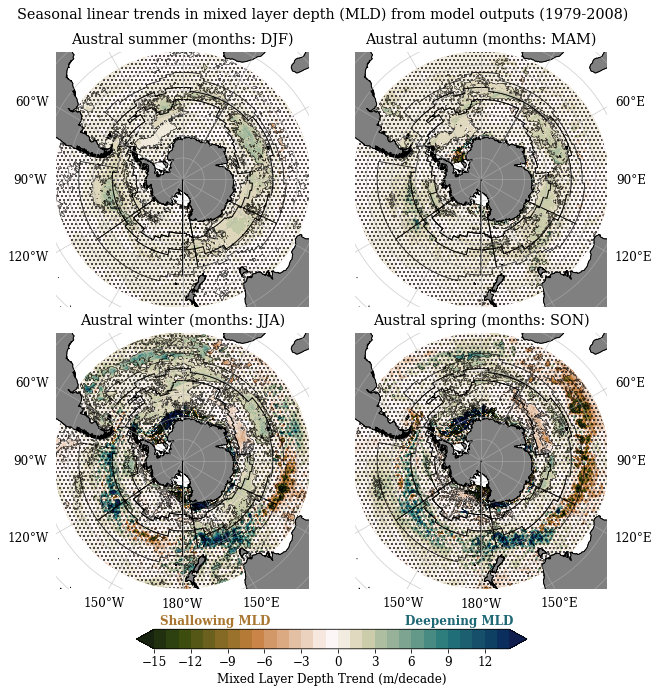

In [15]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Set levels for plotting
levels = np.arange(-15, 15)

#Set NA values to appear as white
cmap = plt.get_cmap(cm.cm.tarn)
cmap.set_bad('white')

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    #Multiplying by 10 to get change in meters per decade
    data = LM_results[season].coefficients*10
    #Plotting
    p1 = data.where(data != 0, np.nan).plot\
    .pcolormesh(ax = ax[season], cmap = cmap,
               transform = ccrs.PlateCarree(), levels = levels,
               # norm = divnorm, 
               add_colorbar = False)
    
    #Plotting significance
    #Extracting only significant values >= 0.05
    sig = xr.where(LM_results[season].p_values >= 0.05, True, 0)
    #Add contour around significant areas
    sig.plot.contour(colors = 'black', transform = ccrs.PlateCarree(),
                     ax = ax[season], add_colorbar = False, linewidths = .1)
    #Adding hatching
    sig.where(sig == 1, np.nan).plot.contourf(hatches = ['...'],
                                              colors = 'none', ax = ax[season],
                                              transform = ccrs.PlateCarree(), 
                                              add_colorbar = False)
    #Add MEASO limits
    MEASO.plot(color = 'none', lw = 0.9, ax = ax[season], edgecolor = 'black',
              alpha = 0.75)
    
    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  label = 'Mixed Layer Depth Trend (m/decade)')

#Add labels to improve readability
#Get colormap to extract colors for labels
cmap = mcm.get_cmap(cm.cm.tarn)
cb.ax.text(5.5, 1.25, 'Deepening MLD', color = cmap(0.85), fontweight = 'bold')
cb.ax.text(-14.5, 1.25, 'Shallowing MLD', color = cmap(0.25), fontweight = 'bold')

fig.suptitle('Seasonal linear trends in mixed layer depth (MLD) from model outputs (1979-2008)', 
             y = 0.93)

fn = 'SeasonalLinearTrends_MLD_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

# Exploring mixed layer depth calculated from observational data 
Observations were obtained from [Sallee et al 2021](https://doi.org/10.1038/s41586-021-03303-x), which include data for mixed layer depth between 1970 and 2018. Version 2 of this dataset was downloaded from their [Zenodo repository](https://zenodo.org/record/5776180#.YcJf8NBBw2w). The second version of this dataset provide a more robust calculation of the monthly climatologies according to the release notes (see the note under `Readme` in the climatology dataset for more information

In [10]:
#Loading the MATLAB data structure containing the climatological data to the notebook
obs = loadmat('/g/data/v45/la6889/GlobalML_Climato_1970_2018.mat')

## Checking all variables included in this data structure
Note that the data structure is loaded as a dictionary in Python. All variables related to climatology are included under the `MLCLimato` key of this dictionary.

In [9]:
obs['MLClimato'].dtype

dtype([('lon', 'O'), ('lat', 'O'), ('ML_temp', 'O'), ('ML_depth', 'O'), ('ML_psal', 'O'), ('ML_temp_BaseMLstratif', 'O'), ('ML_sal_BaseMLstratif', 'O'), ('ML_sal_0_200stratif', 'O'), ('ML_temp_0_200stratif', 'O'), ('ML_temp_stderror', 'O'), ('ML_depth_stderror', 'O'), ('ML_psal_stderror', 'O'), ('ML_temp_BaseMLstratif_stderror', 'O'), ('ML_sal_BaseMLstratif_stderror', 'O'), ('ML_sal_0_200stratif_stderror', 'O'), ('ML_temp_0_200stratif_stderror', 'O'), ('medianyear', 'O'), ('nbobs', 'O'), ('Readme', 'O')])

## Extracting latitude and longitude values
The `MATLAB data structure` appears as data frame nested inside two data frames when loaded using the `loadmat` function from `SciPy`.

In [11]:
lon = obs['MLClimato']['lon'][0][0][:,0]
lat = obs['MLClimato']['lat'][0][0][:,0]

## Extracting monthly climatological means
Monthly climatological means are included under the `ML_depth` variable and as with the coordinates, it is nested within two data frames. A data array is constructed using the climatological means and the previously extracted coordinates before carrying out any analyses.

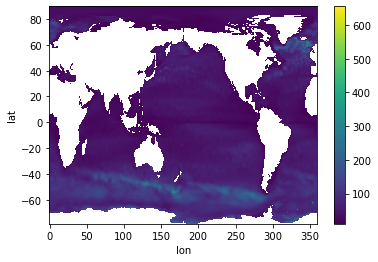

In [12]:
clim_means_obs = xr.DataArray(data = obs['MLClimato']['ML_depth'][0][0], 
                              dims = ['time', 'lat', 'lon'],
                              coords = {'lat': lat, 'lon': lon, 
                                        #Each time step represents a month
                                        'time': range(1, 13)})
#Check resulting data array
clim_means_obs.mean('time').plot()

In [19]:
#Checking min and max values in climatological means
#Version 2 does not include any negative MLD values
clim_means_obs.min(), clim_means_obs.max()

(<xarray.DataArray ()>
 array(0.0100309),
 <xarray.DataArray ()>
 array(6626.03662109))

## Calculating winter and summer climatological means to recreate plots in Sallee et al.

In [20]:
winter_south = clim_means_obs.sel(time = slice(8, 10)).mean('time')
summer_south = clim_means_obs.sel(time = slice(1, 3)).mean('time')

## Plotting results
Recreating Figures 2E and 2F in Sallee et al 2020, which are composite figure showing winter/summer in both hemispheres in the same world map. Limits of colour bars were set to the match the published figures. Note that climatological data from version 2 is not exactly the same as the data used in the publication, so the figures below vary slightly from those published.

### Winter composite

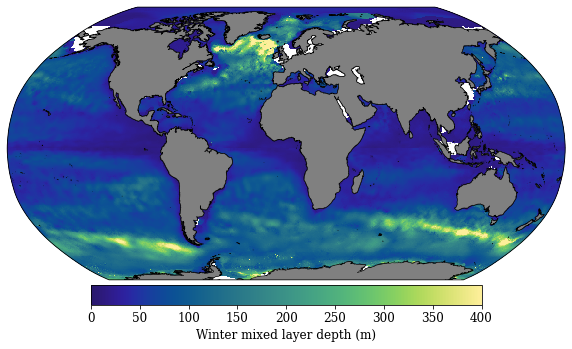

In [21]:
#Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for winter in the northern and southern hemispheres
north = summer_south.sel(lat = slice(0.1, 90))
south = winter_south.sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = north.plot.pcolormesh(vmin = 0, vmax = 400, transform = ccrs.PlateCarree(), ax = ax, 
                           add_colorbar = False, cmap = cm.cm.haline)
south.plot.pcolormesh(vmin = 0, vmax = 400, transform = ccrs.PlateCarree(), ax = ax, 
                      cmap = cm.cm.haline, add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add colorbar at the bottom of the figure
cb = fig.colorbar(p1, ax = ax, orientation = 'horizontal', shrink = 0.7, pad = 0.01, 
                  label  = 'Winter mixed layer depth (m)')

### Summer composite

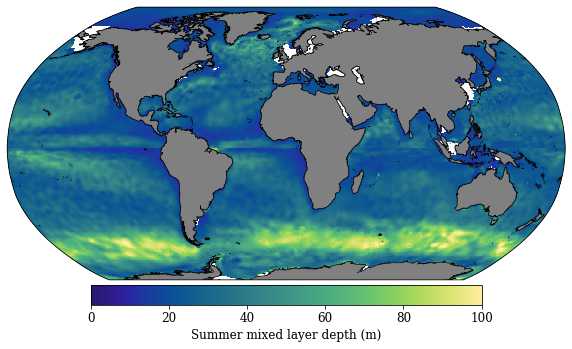

In [22]:
#Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for summer in the northern and southern hemispheres
north = winter_south.sel(lat = slice(0.1, 90))
south = summer_south.sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = north.plot.pcolormesh(vmin = 0, vmax = 100, transform = ccrs.PlateCarree(), ax = ax,
                           add_colorbar = False, cmap = cm.cm.haline)
south.plot.pcolormesh(vmin = 0, vmax = 100, transform = ccrs.PlateCarree(), ax = ax, 
                      cmap = cm.cm.haline, add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add colorbar at the bottom of the figure
cb = fig.colorbar(p1, ax = ax, shrink = 0.7, pad = 0.01, orientation = 'horizontal',
                 label  = 'Summer mixed layer depth (m)')

## Finding location of extreme values
Extreme values are defined here as any values above the maximum limit shown in the colour bars. Composite images are used here.

### Winter composite

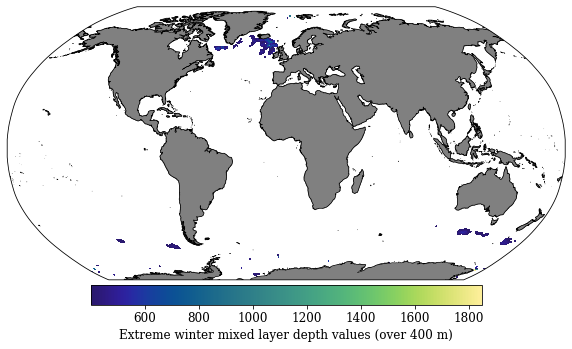

In [23]:
#Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for winter in the northern and southern hemispheres, but only show 
#values above the colourbar limit for the season (400 m)
north = summer_south.where(summer_south > 400, np.nan).sel(lat = slice(0.1, 90))
south = winter_south.where(winter_south > 400, np.nan).sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = north.plot.pcolormesh(transform = ccrs.PlateCarree(), ax = ax, 
                           add_colorbar = False, cmap = cm.cm.haline)
south.plot.pcolormesh(transform = ccrs.PlateCarree(), ax = ax, cmap = cm.cm.haline,
                      add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add a colorbar to the figure
cb = fig.colorbar(p1, ax = ax, orientation = 'horizontal', shrink = 0.7, pad = 0.01,
                 label  = 'Extreme winter mixed layer depth values (over 400 m)')

### Summer composite

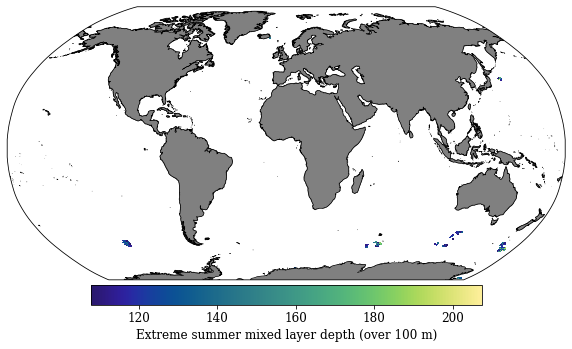

In [24]:
#Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for summer in the northern and southern hemispheres, but only show 
#values above the colourbar limit for the season (400 m)
north = winter_south.where(winter_south > 100, np.nan).sel(lat = slice(0.1, 90))
south = summer_south.where(summer_south > 100, np.nan).sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = north.plot.pcolormesh(transform = ccrs.PlateCarree(), ax = ax, 
                           add_colorbar = False, cmap = cm.cm.haline)
south.plot.pcolormesh(transform = ccrs.PlateCarree(), ax = ax, cmap = cm.cm.haline, 
                      add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add a colorbar to the figure
cb = fig.colorbar(p1, ax = ax, shrink = 0.7, pad = 0.01, orientation = 'horizontal',
                 label  = 'Extreme summer mixed layer depth (over 100 m)')

## Seasonal linear trends
In this section, we replicate Figure 3C from Sallee et al 2020 using the trends data from the version 2 of the published dataset (`GlobalML_Trend_1970_2018.mat` file). The `ML_depth_trend` variable in this file contains the monthly trends, and `ML_depth_stderror` contains the standard errors of the monthly linear trend. Trends are considered to be significant if the absolute trend values is larger than the standard error.

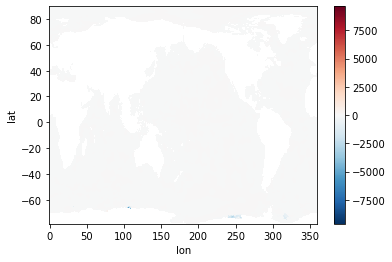

In [13]:
#Loading MATLAB data structure
obs_trends = loadmat('/g/data/v45/la6889/GlobalML_Trend_1970_2018.mat')

#Creating data array with the monthly trends data 
month_trend_obs = xr.DataArray(data = obs_trends['MLtrend']['ML_depth_trend'][0][0],
                               dims = ['time', 'lat', 'lon'],
                               coords = {'lat': lat, 'lon': lon, 
                                         #Monthly data
                                         'time': range(1, 13)})
month_trend_obs.mean('time').plot()

### Calculating mean seasonal trends

In [14]:
winter_trend_south = month_trend_obs.sel(time = slice(8, 10)).mean('time')
summer_trend_south = month_trend_obs.sel(time = slice(1, 3)).mean('time')

### Calculating absolute values for seasonal trends to identify areas of significant change

In [15]:
winter_abs_south = np.fabs(winter_trend_south)
summer_abs_south = np.fabs(summer_trend_south)

## Loading standard error of linear trends

In [14]:
month_se_obs = xr.DataArray(data = obs_trends['MLtrend']['ML_depth_stderror'][0][0],
                            dims = ['time', 'lat', 'lon'],
                            coords = {'lat': lat, 'lon': lon, 
                                      #Montly data
                                      'time': range(1, 13)})
#Checking maximum and minimum values
month_se_obs.min(), month_se_obs.max()

(<xarray.DataArray ()>
 array(0.04194638),
 <xarray.DataArray ()>
 array(103274.30664062))

### Calculating seasonal mean standard errors

In [16]:
winter_se_south = month_se_obs.sel(time = slice(8, 10)).mean('time')
summer_se_south = month_se_obs.sel(time = slice(1, 3)).mean('time')

## Creating mask for non-significant areas

In [17]:
#If absolute trend is smaller than the std error, then mask will have a value of 1,
#otherwise no value will be added. Masks named based on southern hemisphere seasons
mask_winter = xr.where(winter_abs_south < winter_se_south, 1, np.nan)
mask_summer = xr.where(summer_abs_south < summer_se_south, 1, np.nan)

### Creating composite masks
Composite masks show the same season (summer/winter) in both hemispheres

In [18]:
comp_mask_winter = xr.DataArray(data = np.vstack([mask_winter.sel(lat = slice(-90, 0)).values, 
                                                  mask_summer.sel(lat = slice(0.1, 90)).values]),
                                dims = ['lat', 'lon'],
                                coords = {'lat': lat, 'lon': lon})

comp_mask_summer = xr.DataArray(data = np.vstack([mask_summer.sel(lat = slice(-90, 0)).values, 
                                                  mask_winter.sel(lat = slice(0.1, 90)).values]),
                                dims = ['lat', 'lon'],
                                coords = {'lat': lat, 'lon': lon})

## Plotting mean seasonal trends
Note that negative trend values refer to a deepening of the MLD, while positive values represent areas where MLD is shallowing.

### Winter composite

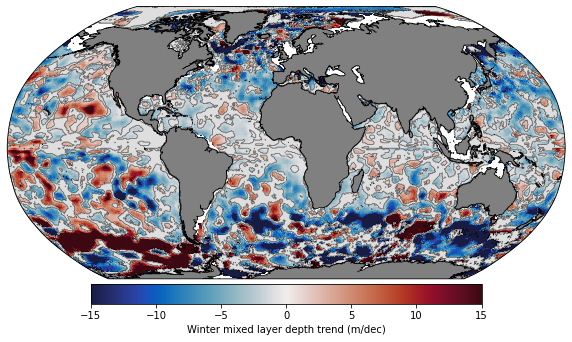

In [19]:
#Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for winter in the northern and southern hemispheres
north_trend = summer_trend_south.sel(lat = slice(0.1, 90))
south_trend = winter_trend_south.sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = north_trend.plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                                 ax = ax, add_colorbar = False, cmap = cm.cm.balance)
south_trend.plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                            ax = ax, cmap = cm.cm.balance, add_colorbar = False)
#Apply mask
comp_mask_winter.plot.contourf(cmap = '#dedede', ax = ax, add_colorbar = False, 
                               transform = ccrs.PlateCarree())
xr.where(comp_mask_winter == 1, True, 0).plot.contour(colors = 'black', ax = ax, 
                                                      add_colorbar = False,
                         transform = ccrs.PlateCarree(), linewidths = 0.1)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add a colorbar to the figure
cb = fig.colorbar(p1, ax = ax, orientation = 'horizontal', shrink = 0.7, pad = 0.01,
                 label  = 'Winter mixed layer depth trend (m/dec)')

### Summer composite

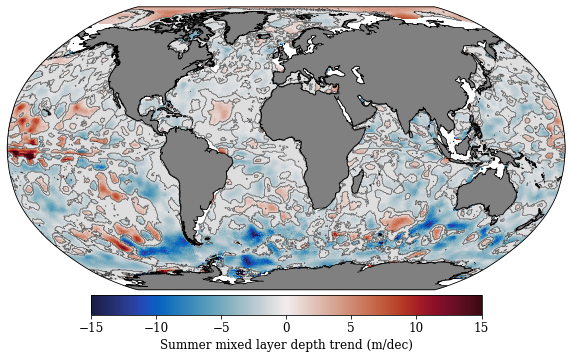

In [33]:
##Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for summer in the northern and southern hemispheres
north_trend = winter_trend_south.sel(lat = slice(0.1, 90))
north_mask = mask_winter.sel(lat = slice(0.1, 90))
south_trend = summer_trend_south.sel(lat = slice(-90, 0))
south_mask = mask_summer.sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = north_trend.plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                                 ax = ax, add_colorbar = False, cmap = cm.cm.balance)
south_trend.plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                            ax = ax, cmap = cm.cm.balance, add_colorbar = False)
comp_mask_summer.plot.contourf(cmap = '#dedede', ax = ax, add_colorbar = False, 
                         transform = ccrs.PlateCarree())
xr.where(comp_mask_summer == 1, True, 0).plot.contour(colors = 'black', ax = ax, add_colorbar = False,
                         transform = ccrs.PlateCarree(), linewidths = 0.1)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add a colorbar to the figure
cb = fig.colorbar(p1, ax = ax, shrink = 0.7, pad = 0.01, orientation = 'horizontal',
                 label  = 'Summer mixed layer depth trend (m/dec)')

# Comparing seasonal climatological means in MLD (observations vs model)

## Separating model data into seasons

In [15]:
seasonNames = {'Summer': [12, 1, 2], 'Autumn': [3, 4, 5], 
              'Winter': [6, 7, 8], 'Spring': [9, 10, 11]}

In [16]:
climdata = SO.sel(time = slice('1970-01', '2018-12'))

seasons_SO = {}

for season in seasonNames.keys():
    y = []
    for i, m in enumerate(climdata.time.dt.month.values.tolist()):
        if m in seasonNames[season]:
            y.append(climdata[i])
    seasons_SO[season] = xr.concat(y, dim = 'time')

### Plotting climatologies from model outputs

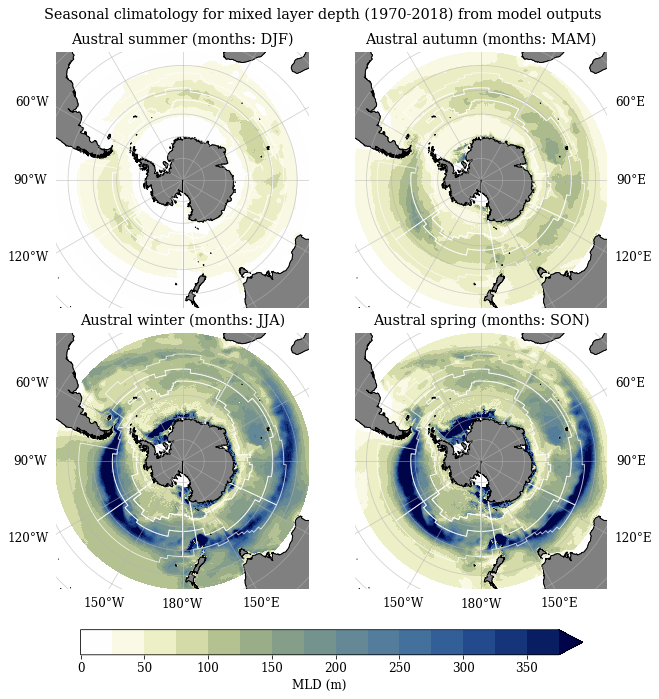

In [36]:
#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

levels = np.arange(0, 400, 25)

#Get a colormap from Scientific Colour Maps
cmap, cmap_r = zsf.colourMaps('../../ScientificColourMaps6/', 'davos', rev = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

#Initialise list to save figure axes
ax = {}
#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    #Add figure to axis
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = seasons_SO[season].mean('time')
    
    #Extract information for each season and start plotting
    p1 = data.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax[season], 
                    #Use colormap created at the beginning of the block and apply log-transformed colormap
                    cmap = cmap_r, levels = levels,#norm = log_norm,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
    
    #Add MEASO limits
    MEASO.plot(color = 'none', lw = 0.9, ax = ax[season], edgecolor = 'white',
              alpha = 0.75)
    
   #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
        
    ax[season].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set shared colourbar for all plots
cb = fig.colorbar(p1, ax = [ax[a] for a in ax], orientation = 'horizontal', 
                  shrink = 0.9, pad = 0.06, extend = 'max',
                  label = varDict['short_name'] + ' (' + varDict['unit'] + ')')
    
fig.suptitle('Seasonal climatology for mixed layer depth (1970-2018) from model outputs',
             y = 0.93)

fn = 'SeasonalClimatology_' + varDict['short_name'] + '_1970-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

## Calculating climatologies from observations
Recalculating seasonal climatologies using our definition of seasons.

In [19]:
#Create empty dictionary to store mean seasonal climatologies
seasonal_clim_obs = {}

for season in seasonNames.keys():
    seasonal_clim_obs[season] = clim_means_obs.sel(time = seasonNames[season], lat = slice(-90, -35)).mean('time')

### Plotting climatologies from observations

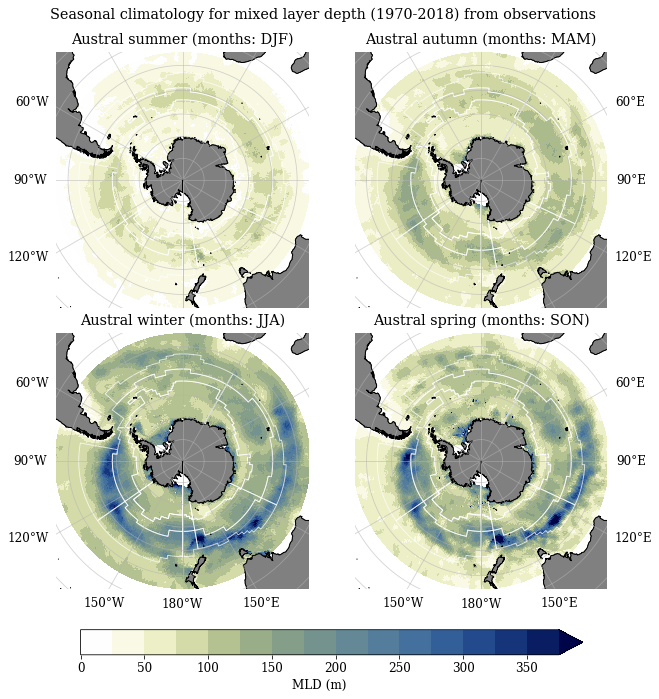

In [18]:
#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Levels for colorbar
levels = np.arange(0, 400, 25)

#Get a colormap from Scientific Colour Maps
cmap, cmap_r = zsf.colourMaps('../../ScientificColourMaps6/', 'davos', rev = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

#Initialise list to save figure axes
ax = {}
#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    #Add figure to axis
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = seasonal_clim_obs[season]
    mask = xr.where(data < 0, 1, np.nan)
    
    #Extract information for each season and start plotting
    p1 = data.plot.pcolormesh(x = 'lon', y = 'lat', ax = ax[season], 
                    #Use colormap created at the beginning of the block
                    cmap = cmap_r, levels = levels,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
    
    mask.plot.contourf(cmap = '#dedede', ax = ax[season], add_colorbar = False, 
                       transform = ccrs.PlateCarree())
    xr.where(mask == 1, True, 0).plot.contour(colors = 'black', ax = ax[season], 
                                              add_colorbar = False, 
                                              transform = ccrs.PlateCarree(), 
                                              linewidths = 0.1)
    
    #Add MEASO limits
    MEASO.plot(color = 'none', lw = 0.9, ax = ax[season], edgecolor = 'white',
              alpha = 0.75)
    
   #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
        
    ax[season].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set shared colourbar for all plots
cb = fig.colorbar(p1, ax = [ax[a] for a in ax], orientation = 'horizontal', 
                  shrink = 0.9, pad = 0.06, extend = 'max',
                  label = varDict['short_name'] + ' (' + varDict['unit'] + ')')

fig.suptitle('Seasonal climatology for mixed layer depth (1970-2018) from observations',
             y = 0.93)

fn = 'SeasonalClimatology_Obs_' + varDict['short_name'] + '_1970-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

## Plotting summer and winter seasons from obs and models side by side

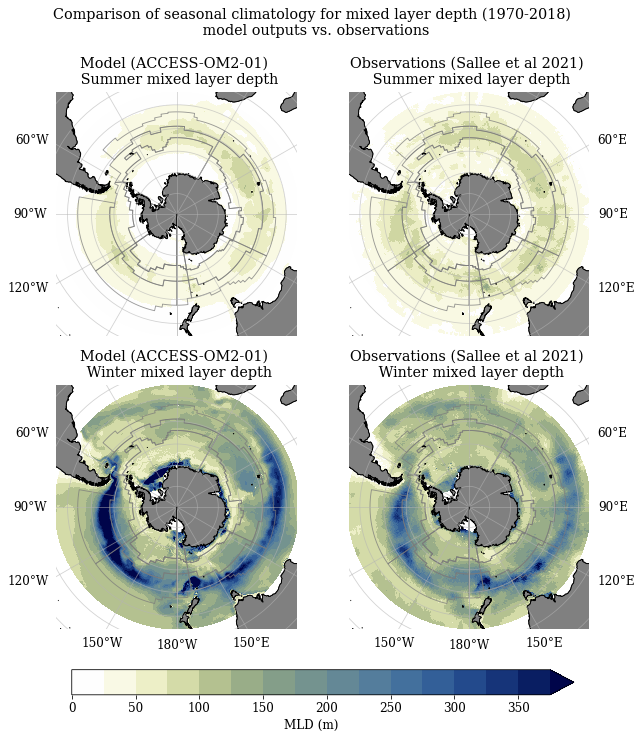

In [19]:
#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Levels for colorbar
levels = np.arange(0, 400, 25)

#Get a colormap from Scientific Colour Maps
cmap, cmap_r = zsf.colourMaps('../../ScientificColourMaps6/', 'davos', rev = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Winter': 'Austral winter (months: JJA)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.1, hspace = 0.2)

#Initiliase dictionary to store axes
ax = {}

for i, data, sea in [(0, 'Model (ACCESS-OM2-01)', 'Summer'), (1, 'Observations (Sallee et al 2021)', 'Summer'), 
                     (2, 'Model (ACCESS-OM2-01)', 'Winter'), (3, 'Observations (Sallee et al 2021)', 'Winter')]:
    ax[i] = fig.add_subplot(gs[i], projection = projection)
    if 'Model' in data:
        mean_season = seasons_SO[sea].mean('time')
        p1 = mean_season.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax[i],
                                  cmap = cmap_r, levels = levels,
                                  transform = ccrs.PlateCarree(), add_colorbar = False)
    elif 'Obs' in data:
        mean_season = seasonal_clim_obs[sea]
        mask = xr.where(mean_season < 0, 1, np.nan)
        p1 = mean_season.plot.pcolormesh(x = 'lon', y = 'lat', ax = ax[i],
                                  cmap = cmap_r, levels = levels,
                                  transform = ccrs.PlateCarree(), add_colorbar = False)
        mask.plot.contourf(cmap = '#dedede', ax = ax[i], add_colorbar = False, 
                       transform = ccrs.PlateCarree())
        xr.where(mask == 1, True, 0).plot.contour(colors = 'black', ax = ax[i], 
                                              add_colorbar = False, 
                                              transform = ccrs.PlateCarree(), 
                                              linewidths = 0.1)
    #Add MEASO limits
    MEASO.plot(color = 'none', lw = 0.9, ax = ax[i], edgecolor = '#7b7b7b',
              alpha = 0.75)
    
    #Set title for each map
    ax[i].set_title(f'{data} \n {sea} mixed layer depth', y = 1.01)
    
    #Remove x and y axes labels
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
      
    #Add land and coastlines
    ax[i].add_feature(land_50m)
    ax[i].coastlines(resolution = '50m')
        
    ax[i].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())
    
    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 2:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]

#Set shared colourbar for all plots
cb = fig.colorbar(p1, ax = [ax[a] for a in ax], orientation = 'horizontal', 
                  shrink = 0.9, pad = 0.06, extend = 'max',
                  label = varDict['short_name'] + ' (' + varDict['unit'] + ')')

fig.suptitle('Comparison of seasonal climatology for mixed layer depth (1970-2018) \n model outputs vs. observations',
             y = 0.975)

fn = 'SeasonalClimatology_Comparisons_Obs-Mod_' + varDict['short_name'] + '_1970-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

## Comparisons with regridded model data

In [17]:
#Empty list to store renamed model data
mod = {}

#Rename coordinates to match observations
for key in seasons_SO:
    mod[key] = seasons_SO[key].rename({'xt_ocean': 'lon', 
                                       'yt_ocean': 'lat'})

In [20]:
#Calculate regridder
reg_coarse = xe.Regridder(mod[key], seasonal_clim_obs[key], 
                          'bilinear')

In [38]:
#Empty list to store regridded model data
reg_mod = {}

#Path to folder to store regridded model data
folder_out = os.path.join(varDict['base_data'], 'Model_Regridded_LowRes')
os.makedirs(folder_out, exist_ok = True)

#Apply regridder
for key in mod:
    reg_mod[key] = reg_coarse(mod[key])
    #Create file name
    fn = f'SeasonalClimatology_{key}_1970-2018_MLD_Model_Reg_LowRes.nc'
    #Save output
    reg_mod[key].to_netcdf(os.path.join(folder_out, fn))

### Loading regridded model data to avoid recalculating

In [21]:
#Getting a list with the full file path of files that need to be loaded
filelist = glob(os.path.join(varDict['base_data'], 'Model_Regridded_LowRes/*.nc'))

#Initialising empty dictionary to store results
reg_mod = {}

#Load data - One entry per season
for season in seasonNames:
    file = [file for file in filelist if season in file]
    reg_mod[season] = xr.open_dataarray(file[0])

## Calculating differences in seasonal climatologies from model outputs and observations

In [23]:
#Initialising empty dictionary to store results
seasonal_clim_mod = {}
clim_dif = {}
mask_clim_dif = {}
per_clim_dif = {}

#Calculate model climatology and differences between datasets
for season in seasonNames:
    seasonal_clim_mod[season] = reg_mod[season].mean('time')
    clim_dif[season] = seasonal_clim_mod[season]-seasonal_clim_obs[season]
    per_clim_dif[season] = (np.fabs(clim_dif[season])/((seasonal_clim_mod[season]+seasonal_clim_obs[season])/2))*100
    upper = seasonal_clim_obs[season]*1.20
    lower = seasonal_clim_obs[season]*0.8
    mask_clim_dif[season] = xr.where((seasonal_clim_mod[season] >= lower) & (seasonal_clim_mod[season] <= upper), 
                                     np.nan, 1)

In [128]:
for key in clim_dif:
    print(f'min {key}: {np.round(clim_dif[key].min().values, 3)}, mean {key}: {np.round(clim_dif[key].mean().values, 3)}, max {key}: {np.round(clim_dif[key].max().values, 3)}')

min Summer: -83.295, mean Summer: -13.94, max Summer: 84.669
min Autumn: -230.276, mean Autumn: -10.799, max Autumn: 181.825
min Winter: -1234.354, mean Winter: 21.129, max Winter: 1556.287
min Spring: -1445.81, mean Spring: 41.953, max Spring: 1999.904


### Loading sea ice concentration data (obs and model)

In [42]:
#Models
mod = '/g/data/v45/la6889/Calculations/SeaIceArea/Data/SeasonalClimatology_SIC_1970-2018.nc'
SIC_mod = xr.open_dataarray(file)

#Observations
obs = glob('/g/data/v45/la6889/Observations/SeasonalClimatology/*.nc')
SIC_obs = {}
for key in seasonNames:
    file = [f for f in obs if key in f]
    SIC_obs[key] = xr.open_dataarray(file[0])

### Plotting differences in seasonal climatologies (model-obs)

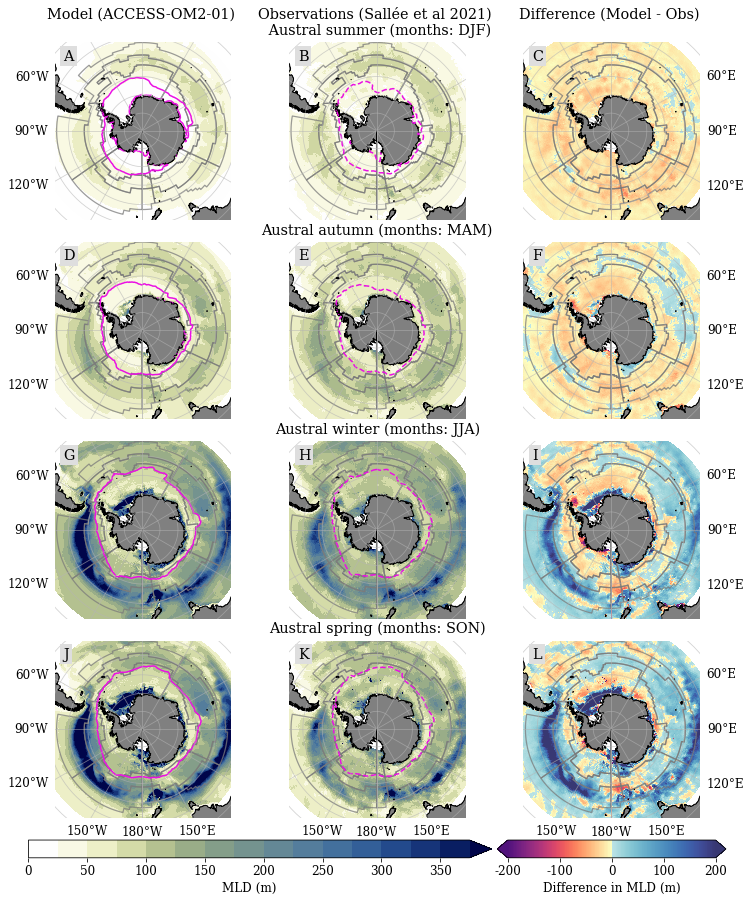

In [61]:
#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (12.5, 15))

#######
###Colorbar settings
#Levels for colorbar
clim_levels = np.arange(0, 400, 25)
diff_levels = np.arange(-100, 100, 25)
contour_levels = np.concatenate((np.arange(-1500., -199, 500), 
                                 np.arange(-100, 101, 50),
                                 np.arange(300, 2000, 500)))

#Get a colormap from Scientific Colour Maps for absolute MLD values
cmap, cmap_r = zsf.colourMaps('../../ScientificColourMaps6/', 'davos', rev = True)

#Create colormap for differences
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -200, vcenter = 0, vmax = 200)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
#Set NA values to show as white
mymap.set_bad('white')
#######

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

#Creating counter for plotting loop
#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}
#Defining datasets to be plotted
data = ['Model (ACCESS-OM2-01)', 
        'Observations (Sallée et al 2021)', 
        'Difference (Model - Obs)']
#Merge seasons and datasets
counter = zip(cycle(data), np.repeat(list(seasonName), len(data)))

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = len(seasonName)+1, ncols = len(data),
                       height_ratios = (1, 1, 1, 1, 0.1))
#Change the width between each plot
gs.update(wspace = 0.025, hspace = 0.15)

#Initiliase dictionary to store axes
ax = {}

#Creating plot using loops
for i, coord in enumerate(counter):   
    ax[i] = fig.add_subplot(gs[i], projection = projection)
    if 'ACCESS' in coord[0]:
        p1 = seasons_SO[coord[1]].mean('time').\
        plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax[i],
                                  cmap = cmap_r, levels = clim_levels,
                                  transform = ccrs.PlateCarree(), add_colorbar = False)
        SIC_mod.sel(season = coord[1]).plot.contour(x = 'xt_ocean', y = 'yt_ocean', 
                                                    ax = ax[i], levels = [0.15],
                                                    transform = ccrs.PlateCarree(),
                                                    colors = '#ea11e3',
                                                    add_colorbar = False)
    elif 'Sal' in coord[0]:
        p1 = seasonal_clim_obs[coord[1]].plot.pcolormesh(x = 'lon', y = 'lat', ax = ax[i],
                                  cmap = cmap_r, levels = clim_levels,
                                  transform = ccrs.PlateCarree(), add_colorbar = False)
        SIC_obs[coord[1]].plot.contour(levels = [.15], ax = ax[i], 
                                       colors = '#ea11e3',
                                       linestyles = 'dashed')
    else:
        p2 = clim_dif[coord[1]].plot.pcolormesh(x = 'lon', y = 'lat', ax = ax[i],
                                                cmap = mymap, norm = divnorm, 
                                                transform = ccrs.PlateCarree(), 
                                                add_colorbar = False)
        
    #Add MEASO limits
    MEASO.plot(color = 'none', lw = 1.25, ax = ax[i], edgecolor = '#7b7b7b',
              alpha = 0.75)
    
    #Set title for each map
    if i < 3 and 'Sal' in coord[0]:
        ax[i].set_title(f'{coord[0]} \n {seasonName[coord[1]]}', y = 1.01)
    elif i < 3:
        ax[i].set_title(f'{coord[0]} \n', y = 1.01)
    elif i > 3 and 'Sal' in coord[0]:
        ax[i].set_title(f'{seasonName[coord[1]]}', y = 1.01)
    else:
        ax[i].set_title('')
    
    #Remove x and y axes labels
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
      
    #Add land and coastlines
    ax[i].add_feature(land_50m)
    ax[i].coastlines(resolution = '50m')
    #Set extent shown
    ax[i].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())
    
    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 7
    gl.ypadding = 7
    gl.xlabels_top = False
    if i in [0, 3, 6]:
        gl.xlabels_left = True
        gl.ylabels_bottom = False
        gl.xlabels_bottom = False
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i in [1, 4, 7]:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.ylabels_bottom = False
        gl.xlabels_bottom = False
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i in [2, 5, 8]:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.ylabels_bottom = False
        gl.xlabels_bottom = False
        gl.xlabels_right = True
    elif i == 9:
        gl.xlabels_left = True
        gl.xlabels_bottom = True
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i == 10:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.xlabels_bottom = True
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i == 11:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.xlabels_bottom = True
        gl.xlabels_right = True
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]

ax_col = fig.add_subplot(gs[-1, 0:2])
cb = plt.colorbar(p1, cax = ax_col, orientation = 'horizontal', 
                  extend = 'max', shrink = 0.5,
                  label = varDict['short_name'] + ' (' + varDict['unit'] + ')')

ax_dif = fig.add_subplot(gs[-1, -1])
cb_dif = plt.colorbar(p2, cax = ax_dif, orientation = 'horizontal', 
                  extend = 'both', shrink = 0.5,
                  label = 'Difference in MLD (' + varDict['unit'] + ')')

cb_dif.set_ticks([-200, -100, 0, 100, 200])
cb_dif.set_ticklabels([-200, -100, 0, 100, 200])

#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:12]
#Apply labels only to plots, not colorbars
for a in ax:
    if a < 12:
        ax[a].text(0.05, .9, labels[a], transform = ax[a].transAxes, 
                   fontsize = 'large',
                   bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

# fig.suptitle('Comparison of seasonal mixed layer depth climatology (1970-2018) \n model outputs vs. observations',
#              y = 0.95)

# fn = 'AllSeasonsClim_Comp_Mod-Obs_' + varDict['short_name'] + '_1970-2018.png'
fn = 'AllSeasonsClim_Comp_Mod-Obs_NoCont_NoTitle' + varDict['short_name'] + '_1970-2018.png'
# fn = 'AllSeasonsClim_Comp_Mod-Obs_Masked' + varDict['short_name'] + '_1970-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Comparing linear trends in MLD (observations vs model)

## Calculating linear trends for model data

In [52]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Calculating linear trend for each season
for season in seasonName:
    #Define file name
    fn = f'LinearTrend_MLD_{season}_1970-2018.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SO[season].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SO[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SO[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SO[season].xt_ocean.values, 
                                        yt_ocean = seasons_SO[season].yt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SO[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SO[season].xt_ocean.values, 
                                        yt_ocean = seasons_SO[season].yt_ocean.values),
                          name = "p_values")
    
    std_err = xr.DataArray(data = se.reshape(seasons_SO[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SO[season].xt_ocean.values, 
                                        yt_ocean = seasons_SO[season].yt_ocean.values),
                          name = "std_err")

    LM_results = xr.merge([coef_r, pval_r, std_err])

    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends to avoid recalculating

In [62]:
#Get a list of files in the linear trend folder
filelist = glob(os.path.join(varDict['linear_trends'], '*1970*.nc'))

#Empty dictionary to save results
LM_results = {}

#Load the files into memory
for season in seasonNames:
    file = [file for file in filelist if season in file]
    LM_results[season] = xr.open_dataset(file[0])

In [134]:
for key in LM_results:
    sig_results = LM_results[key].coefficients.where(np.fabs(LM_results[key].coefficients) > LM_results[key].std_err, np.nan)
    print(f'min {key}: {np.round(sig_results.min().values*10, 3)}, mean {key}: {np.round(sig_results.mean().values*10, 3)}, max {key}: {np.round(sig_results.max().values*10, 3)}')

min Summer: -4.381, mean Summer: 0.795, max Summer: 6.425
min Autumn: -30.118, mean Autumn: 0.762, max Autumn: 19.871
min Winter: -77.019, mean Winter: -0.138, max Winter: 95.666
min Spring: -106.579, mean Spring: -0.858, max Spring: 103.378


## Plotting seasonal linear trends from model data

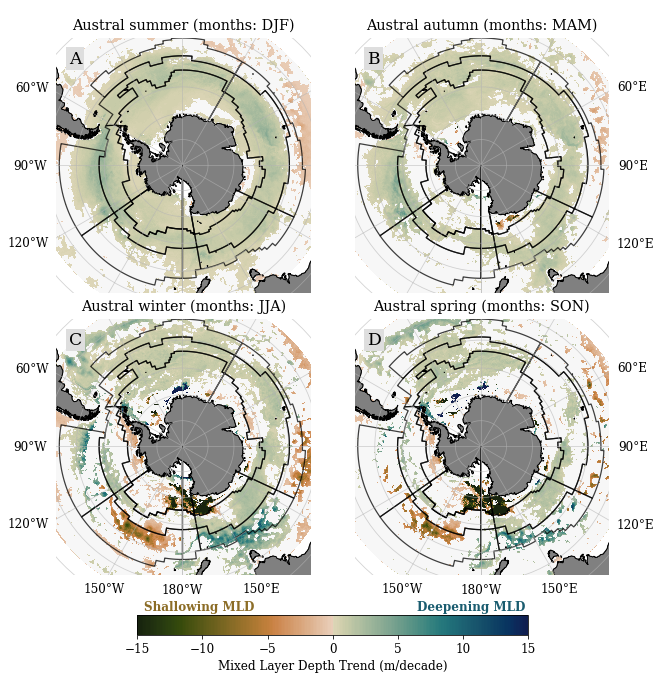

In [71]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Set labels for plotting
levels = np.arange(-15, 15)

#Create colormap for differences
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -15, vcenter = 0, vmax = 15)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = cm.cm.tarn(np.linspace(0, 0.425, 128))
colors2 = cm.cm.tarn(np.linspace(0.575, 1, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
#Set NA values to show as white
mymap.set_bad('white')
#######

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:4]

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_results[season].coefficients
    #Standard errors
    se = LM_results[season].std_err
    
    #Create mask to cover non-significant trends (i.e., absolute trends less than std error
    #of trend)
    mask = xr.where(np.fabs(data) < se, 1, np.nan) 
    
    ###Plotting
    #Multiplying trends by -10 to get change in meters per decade
    p1 = (data*10).plot.pcolormesh(ax = ax[season], cmap = mymap,
                              transform = ccrs.PlateCarree(), 
                              vmin = -15, vmax = 15, add_colorbar = False)
    #Apply mask
    mask.plot.contourf(colors = '#f7f7f7', ax = ax[season],
                       transform = ccrs.PlateCarree(), 
                       add_colorbar = False)
    
    #Add MEASO limits
    MEASO.plot(color = 'none', lw = 1.25, ax = ax[season], edgecolor = 'black',
              alpha = 0.75)
    
    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Colorbar settings
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  label = 'Mixed Layer Depth Trend (m/decade)')

#Add labels to improve readability
#Get colormap to extract colors for labels
cmap = mcm.get_cmap(mymap)
cb.ax.text(6.5, 1.25, 'Deepening MLD', color = cmap(0.85), fontweight = 'bold')
cb.ax.text(-14.5, 1.25, 'Shallowing MLD', color = cmap(0.25), fontweight = 'bold')

#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.05, .9, labels[i], transform = ax[a].transAxes, 
               fontsize = 'x-large',
               bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

# # fig.suptitle('Seasonal linear trends in mixed layer depth (MLD) from model outputs (1970-2018)', 
# #              y = 0.93)

# fn = 'SeasonalLinearTrends_MLD_1970-2018.png'
fn = 'SeasonalLinearTrends_MLD_1970-2018_NoTitle.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

## Clipping trend data into sectors and seasons

In [131]:
#Ensuring output folder exists
out_folder = varDict['clipped_data']
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_MLD_trends = {}

#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    mask = MEASOregions[sector]
    for season in seasonNames:
        clipped_trends = LM_results[season]*mask
        clipped_MLD_trends[f'{sector}_{season}'] = clipped_trends.coefficients.where(np.fabs(clipped_trends.coefficients) > clipped_trends.std_err, np.nan)
        #Create name for output file
        fn = f'MLD_trends_{sector}_{season}_1970-2018.nc'
        clipped_MLD_trends[f'{sector}_{season}'].to_netcdf(os.path.join(out_folder, fn))

### Loading clipped data to avoid recalculation

In [126]:
filelist = glob(os.path.join(varDict['clipped_data'], '*trends*.nc'))

#Create empty list to save clipped data 
clipped_MLD_trends = {}

for sector in sectorNames:
    files_sec = [f for f in filelist if sector in f]
    for season in seasonNames:
        fn = [f for f in files_sec if season in f]
        clipped_MLD_trends[f'{sector}_{season}'] = xr.open_dataarray(fn[0])

In [133]:
for key in clipped_MLD_trends:
    print(f'min {key}: {np.round(clipped_MLD_trends[key].min().values*10, 3)}, mean {key}: {np.round(clipped_MLD_trends[key].mean().values*10, 3)}, max {key}: {np.round(clipped_MLD_trends[key].max().values*10, 3)}')

min West Pacific Antarctic_Summer: -4.381, mean West Pacific Antarctic_Summer: 0.696, max West Pacific Antarctic_Summer: 2.527
min West Pacific Antarctic_Autumn: -7.606, mean West Pacific Antarctic_Autumn: 0.815, max West Pacific Antarctic_Autumn: 10.337
min West Pacific Antarctic_Winter: -56.347, mean West Pacific Antarctic_Winter: -3.477, max West Pacific Antarctic_Winter: 30.07
min West Pacific Antarctic_Spring: -106.579, mean West Pacific Antarctic_Spring: -8.265, max West Pacific Antarctic_Spring: 29.766
min West Pacific Subantarctic_Summer: 0.212, mean West Pacific Subantarctic_Summer: 1.192, max West Pacific Subantarctic_Summer: 3.323
min West Pacific Subantarctic_Autumn: -0.834, mean West Pacific Subantarctic_Autumn: 1.054, max West Pacific Subantarctic_Autumn: 3.38
min West Pacific Subantarctic_Winter: -11.111, mean West Pacific Subantarctic_Winter: -0.91, max West Pacific Subantarctic_Winter: 3.562
min West Pacific Subantarctic_Spring: -24.926, mean West Pacific Subantarctic_

### Loading clipped area data per sector

In [8]:
filelist = glob(os.path.join('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/AllMEASOsectors', '*.nc'))

#Create empty list to save clipped data 
area = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    area[sector] = xr.open_dataarray(fn[0])

## Loading mean seasonal trends from observations
Mean trends are recalculated to coincide with our definition of seasons.

In [27]:
LM_results_obs = {}

for season in seasonNames.keys():
    y = []
    for i, m in enumerate(month_trend_obs.time.values.tolist()):
        if m in seasonNames[season]:
            y.append(month_trend_obs[i])
    LM_results_obs[season] = xr.concat(y, dim = 'time').sel(lat = slice(-90, -35)).mean('time')

## Loading mean seasonal standard errors from observations
Mean standard errors are recalculated to coincide with our definition of seasons.

In [28]:
LM_se_obs = {}

for season in seasonNames.keys():
    y = []
    for i, m in enumerate(month_se_obs.time.values.tolist()):
        if m in seasonNames[season]:
            y.append(month_se_obs[i])
    LM_se_obs[season] = xr.concat(y, dim = 'time').sel(lat = slice(-90, -35)).mean('time')

## Plotting seasonal linear trends from observations

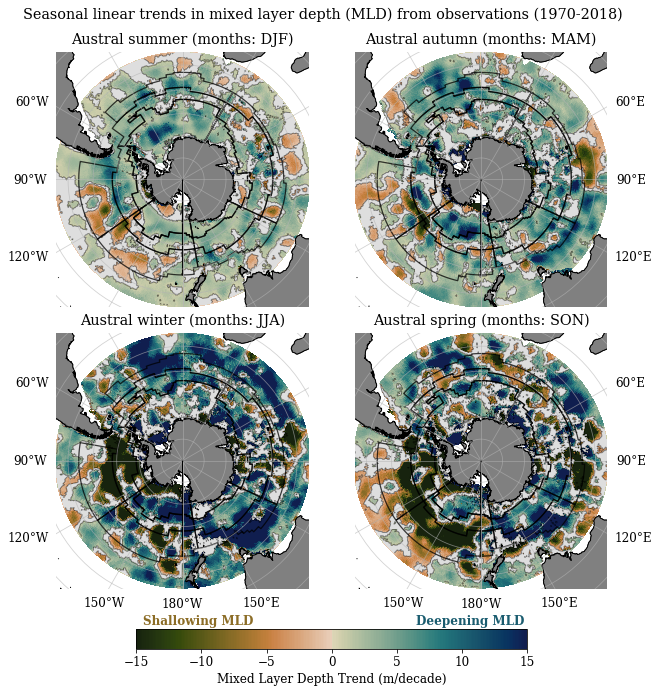

In [36]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

# #Set NA values to appear as white
# cmap = plt.get_cmap(cm.cm.tarn_r)
# cmap.set_bad('white')

#Create colormap for differences
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -15, vcenter = 0, vmax = 15)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = cm.cm.tarn(np.linspace(0, 0.425, 128))
colors2 = cm.cm.tarn(np.linspace(0.575, 1, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
#Set NA values to show as white
mymap.set_bad('white')
#######

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_results_obs[season]
    #Standard errors
    se = LM_se_obs[season]
    
    #Create mask to cover non-significant trends (i.e., absolute trends less than std error
    #of trend)
    mask = xr.where(np.fabs(data) < se, 1, np.nan) 
    
    ###Plotting
    #Multiplying trends by -10 to get change in meters per decade
    p1 = (-data).plot.pcolormesh(ax = ax[season], cmap = mymap,
                              transform = ccrs.PlateCarree(), #levels = levels,
                              vmin = -15, vmax = 15, add_colorbar = False)
    #Apply mask
    mask.plot.contourf(cmap = '#dedede', ax = ax[season], add_colorbar = False, 
                       transform = ccrs.PlateCarree())
    xr.where(mask == 1, True, 0).plot.contour(colors = 'black', ax = ax[season], 
                                              add_colorbar = False, 
                                              transform = ccrs.PlateCarree(), 
                                              linewidths = 0.1)

    #Add MEASO limits
    MEASO.plot(color = 'none', lw = 1.25, ax = ax[season], edgecolor = 'black',
              alpha = 0.75)
    
    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  label = 'Mixed Layer Depth Trend (m/decade)')

#Add labels to improve readability
#Get colormap to extract colors for labels
cmap = mcm.get_cmap(mymap)
cb.ax.text(6.5, 1.25, 'Deepening MLD', color = cmap(0.85), fontweight = 'bold')
cb.ax.text(-14.5, 1.25, 'Shallowing MLD', color = cmap(0.25), fontweight = 'bold')

fig.suptitle('Seasonal linear trends in mixed layer depth (MLD) from observations (1970-2018)', 
             y = 0.93)

fn = 'SeasonalLinearTrends_Obs_MLD_1970-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Comparisons with regridded model data

In [46]:
#Empty list to store renamed model data
mod = {}

#Rename coordinates to match observations
for key in seasons_SO:
    mod[key] = seasons_SO[key].rename({'xt_ocean': 'lon', 
                                       'yt_ocean': 'lat'})

In [47]:
#Calculate regridder
reg_coarse = xe.Regridder(mod[key], seasonal_clim_obs[key], 
                          'bilinear')

In [48]:
#Empty list to store regridded model data
reg_mod = {}

#Apply regridder
for key in mod:
    reg_mod[key] = reg_coarse(mod[key])

In [49]:
#Mask negative values from observations prior to comparisons
obs_no_neg = {}

for key in seasonal_clim_obs:
    obs_no_neg[key] = xr.where(seasonal_clim_obs[key] < 0, np.nan,
                               seasonal_clim_obs[key])

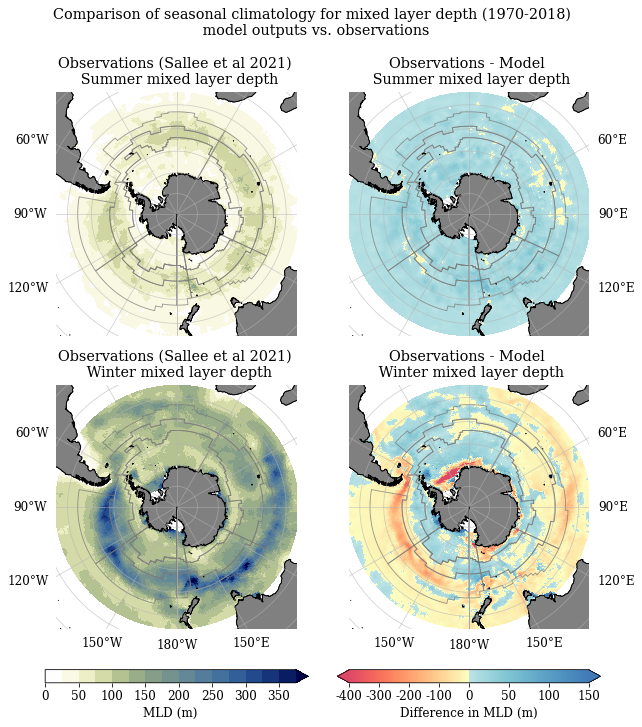

In [50]:
#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Colormap settings
#Levels for colorbar
levels = np.arange(0, 400, 25)
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -400, vcenter = 0, vmax = 150)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.6, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.5, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.\
from_list('my_colormap', colors)
mymap.set_bad('white')
#Get a colormap from Scientific Colour Maps for observations
cmap, cmap_r = zsf.colourMaps('../../ScientificColourMaps6/', 'davos', rev = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Winter': 'Austral winter (months: JJA)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.1, hspace = 0.2)

#Initiliase dictionary to store axes
ax = {}

for i, data, sea in [(0, 'Observations (Sallee et al 2021)', 'Summer'), 
                     (1, 'Model (ACCESS-OM2-01)', 'Summer'), 
                     (2, 'Observations (Sallee et al 2021)', 'Winter'), 
                     (3, 'Model (ACCESS-OM2-01)', 'Winter')]:
    ax[i] = fig.add_subplot(gs[i], projection = projection)
    if 'Obs' in data:
        p_obs = obs_no_neg[sea].plot.pcolormesh(x = 'lon', y = 'lat', ax = ax[i],
                                  cmap = cmap_r, levels = levels,
                                  transform = ccrs.PlateCarree(), 
                                                add_colorbar = False)
    elif 'Model' in data:
        mean_season = obs_no_neg[sea]-reg_mod[sea].mean('time')
        p_mod = mean_season.plot.\
        pcolormesh(x = 'lon', y = 'lat', ax = ax[i],
                   cmap = mymap, norm = divnorm,
                   transform = ccrs.PlateCarree(), 
                   add_colorbar = False)
    #Add MEASO limits
    MEASO.plot(color = 'none', lw = 0.9, ax = ax[i], edgecolor = '#7b7b7b',
              alpha = 0.75)
    
    #Set title for each map
    if i%2 == 0:
        ax[i].set_title(f'{data} \n {sea} mixed layer depth', y = 1.01)
    else:
        ax[i].set_title(f'Observations - Model \n {sea} mixed layer depth',
                        y = 1.01)
    
    #Remove x and y axes labels
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
      
    #Add land and coastlines
    ax[i].add_feature(land_50m)
    ax[i].coastlines(resolution = '50m')
        
    ax[i].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())
    
    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 2:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]

#Set shared colourbar for all plots
cb_obs = fig.colorbar(p_obs, ax = [ax[a] for a in ax if a%2 == 0], 
                  orientation = 'horizontal', 
                  shrink = 0.99, pad = 0.06, extend = 'max',
                  label = varDict['short_name'] + ' (' + varDict['unit'] + ')')

cb_mod = fig.colorbar(p_mod, ax = [ax[a] for a in ax if a%2 != 0], 
                  orientation = 'horizontal', 
                  shrink = 0.99, pad = 0.06, extend = 'both',
                  label = 'Difference in MLD (' + varDict['unit'] + ')')
#Show colorbar ticks
cb_mod.set_ticks([-400, -300, -200, -100, 0, 50, 100, 150])
cb_mod.set_ticklabels([-400, -300, -200, -100, 0, 50, 100, 150])

fig.suptitle('Comparison of seasonal climatology for mixed layer depth (1970-2018) \n model outputs vs. observations',
             y = 0.975)

fn = 'SeasonalClimatology_Comparisons_Obs-ModReg_' + varDict['short_name'] + '_1970-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)